## Purpose
By taking a directory of SEM images from a given experiment, we want to segment AND classify every image such that we can begin looking at the data as a whole

In [1]:
# General Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stat
import numpy as np 
#import forestsci
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
import pickle
import glob
import copy

import sys
sys.path.append("..")
from Utility.segmentation_utils import * 

image_folder = "../Images/Additional" # Path to folder, adjust for other machines
result_folder = "../Results"
model_folder = "../Models"
image_list_Si = glob.glob(f'{image_folder}/Si embed/*')
image_list_Yuanwei = glob.glob(f'{image_folder}/Images to rachel (from Yuanwei)/*/*') # Might want to separate this?



In [2]:
# Define which image paths to run
parent_experiment = "L1_2.5_5_10_nM"
all_experiments = glob.glob(os.path.join(image_folder,parent_experiment,"*"))
print(all_experiments)

# Load models
model_names = ["RF_C-MC_I-P.sav","RF_C_MC.sav","RF_I_P.sav"]
rf_CMC_IP, rf_C_MC, rf_I_P = [pickle.load(open(os.path.join(model_folder,model), 'rb'))\
                              for model in model_names]

# Define Features WHICH MUST MATCH WHAT ALL THREE MODELS WERE TRAINED ON
features=['area',
#        'equivalent_diameter', 
#        'orientation', 
    'major_axis_length',
    'minor_axis_length',
    'perimeter',
#        'min_intensity',
#        'mean_intensity',
        'max_intensity',
    'solidity',
    'major_axis_length/minor_axis_length',
    'perimeter/major_axis_length',
    'perimeter/minor_axis_length',
          'feret_diameter_max',
      'moments_hu-0',
      'moments_hu-1',
      'moments_hu-2',
      'moments_hu-3',
#      'moments_hu-4',
      'moments_hu-5',
#      'moments_hu-6',
#    'eccentricity'
         ]

['../Images/Additional/L1_2.5_5_10_nM/L1 10nM', '../Images/Additional/L1_2.5_5_10_nM/L1 5nM', '../Images/Additional/L1_2.5_5_10_nM/L1 2.5 nM']


/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# Define key helper functions
def assign_label(predicted_data,mode="C-MC_I-P"):
    '''
    Given an array of arrays, get the max column, associate that with a name, and return the fully labeled list
    Should work with 3 given modes
    '''
    valid_modes = ["C-MC_I-P","C_MC","I_P"]
    if mode not in valid_modes:
        print(f'Error: {mode} not supported')
        return -1
    label_arr = []
    for data in predicted_data:
        index = np.argmax(data)
        if mode == valid_modes[0]:
            if index == 0:
                label_arr.append("Crystal")
            if index == 1:
                label_arr.append("Incomplete")
                
        elif mode == valid_modes[1]:
            if index == 0:
                label_arr.append("Crystal")
            if index == 1:
                label_arr.append("Multiple Crystal")
                
        elif mode == valid_modes[2]:
            if index == 0:
                label_arr.append("Incomplete")
            if index == 1:
                label_arr.append("Poorly Segmented")
    return label_arr

def apply_coloring(IS,df_labeled):
    '''
    To aid study of an image, apply a colored filter over image such that we can see which regions
    are classified as which
    '''
    C_color = np.array([0,255,0])
    MC_color = np.array([255,255,0])
    I_color = np.array([255,0,0])
    P_color = np.array([0,0,255])
    color_arr = [C_color,MC_color,I_color,P_color]
    match_arr = ["Crystal","Multiple Crystal", "Incomplete", "Poorly Segmented"]
    
    region_arr = IS.grab_region_array(focused=False)
    mod_image = cv2.cvtColor(IS.img2,cv2.COLOR_BGR2RGB)
    mask_image = copy.deepcopy(mod_image)*0
    for ii in np.arange(len(labeled_arr)):
            id_label = df_labeled.at[ii,"Labels"] # assumed sorted
            color = color_arr[match_arr.index(id_label)]
            mask_image[region_arr[ii] > 0] = color
    
    final_image = cv2.addWeighted(mod_image,1,mask_image,.3,0)
    return final_image    

In [4]:
debug = []
for experiment in all_experiments[:1]:
    print(experiment)
    df_experiment = pd.DataFrame()
    experiment_images = glob.glob(os.path.join(experiment,'*')) # Beware non-images
    
    for individual_image in experiment_images:
        print(individual_image)
        IS = ImageSegmenter(individual_image)
        df_image = IS.df

        # Numerical errors (divide by 0)
        df_image.replace([np.inf, -np.inf], np.nan, inplace=True)
        for feature in features:
            df_image.dropna(subset=[feature],inplace=True)
            
        ### Split Crystal & Multicrystal from Incomplete & Poorly Segmented###
        # Split Data
        X=df_image[features]

        predicted_data = rf_CMC_IP.predict(X)
        labeled_arr = assign_label(predicted_data)
        df_image['Labels'] = labeled_arr
        print("BIG SEPARATOR")
        print(np.unique(labeled_arr))
        
        #### Subdividing further ####
        df_image_sublist = []
        for label in ['Crystal','Incomplete']:
            df_image_temp = df_image[df_image['Labels'] == label]
            rf_temp = rf_C_MC if label == 'Crystal' else rf_I_P
            label_mode = "C_MC" if label == 'Crystal' else "I_P"
            X_temp = df_image_temp[features]

            try:
                predicted_data_temp = rf_temp.predict(X_temp)
            except:
                print(f'Prediction failed on {label}, maybe 0 elements?')
                predicted_data_temp = []
            print(predicted_data_temp)
            labeled_arr = assign_label(predicted_data_temp,mode=label_mode)
            df_image_temp['Labels'] = labeled_arr
            print(np.unique(df_image_temp["Labels"]))
            df_image_sublist.append(df_image_temp)

        df_image = pd.concat(df_image_sublist)
        df_image.sort_values(by="Region",inplace=True)
        debug = (individual_image,df_image)

        df_experiment = pd.concat([df_experiment,df_image])
    print(np.unique(df_image["Labels"]))
    df_experiment.to_csv(os.path.join(result_folder,experiment.split("/")[-1]))


../Images/Additional/L1_2.5_5_10_nM/L1 10nM
../Images/Additional/L1_2.5_5_10_nM/L1 10nM/L1_10nM_09.tif
Image Segmenter on L1_10nM_09 created!
[1 2 3 4 5 6]
BIG SEPARATOR
['Incomplete']
Prediction failed on Crystal, maybe 0 elements?
[]
[]
[[0.52356771 0.47643229]
 [0.76824157 0.23175843]
 [0.78991815 0.21008185]
 [0.59906994 0.40093006]
 [0.63208705 0.36791295]
 [0.5031436  0.4968564 ]]
['Incomplete']
../Images/Additional/L1_2.5_5_10_nM/L1 10nM/L1_10nM_10.tif
Image Segmenter on L1_10nM_10 created!
[1 2 3 4 5 6 7 8 9]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.81285342 0.18714658]]
['Crystal']
[[0.66651166 0.33348834]
 [0.54927455 0.45072545]
 [0.52263145 0.47736855]
 [0.76839658 0.23160342]
 [0.54882813 0.45117187]
 [0.74575273 0.25424727]
 [0.65852555 0.34147445]
 [0.72065972 0.27934028]]
['Incomplete']
../Images/Additional/L1_2.5_5_10_nM/L1 10nM/L1_10nM_03.tif
Image Segmenter on L1_10nM_03 created!
[1 2 3 4 5]
BIG SEPARATOR
['Crystal']
[[0.6999504  0.3000496 ]
 [0.52353671 0.47646329

/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: divide by zero encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: divide by zero encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis

[  1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.6812748  0.3187252 ]
 [0.65361483 0.34638517]
 [0.74193567 0.25806433]
 [0.89122024 0.10877976]
 [0.88856027 0.11143973]
 [0.57783978 0.42216022]
 [0.86781994 0.13218006]
 [0.59563492 0.40436508]
 [0.75107887 0.24892113]
 [0.49676959 0.50323041]
 [0.85507812 0.14492188]
 [0.61864459 0.38135541]
 [0.84661458 0.15338542]
 [0.67119296 0.32880704]
 [0.7094122  0.2905878 ]
 [0.72604167 0.27

/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: divide by zero encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


Image Segmenter on L1_10nM_01 created!
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.88457961 0.11542039]
 [0.57604787 0.42395213]
 [0.76049107 0.23950893]
 [0.70104167 0.29895833]
 [0.57385293 0.42614707]
 [0.65513393 0.34486607]
 [0.51810516 0.48189484]
 [0.84544271 0.15455729]
 [0.59284474 0.40715526]
 [0.70963542 0.29036458]
 [0.6735119  0.3264881 ]
 [0.68973834 0.31026166]
 [0.72956969 0.27043031]
 [0.79966518 0.20033482]
 [0.56968626 0.43031374]
 [0.76046245 0.23953755]
 [0.85883557 0.14116443]
 [0.51637525 0.48362475]
 [0.60123388 0.39876612]
 [0.55869296 0.44130704]
 [0.58687376 0.41312624]
 [0.68461682 0.31538318]
 [0.6328187  0.3671813 ]]
['Crystal']
[[0.54551711 0.45448289]
 [0.75146949 0.24853051]
 [0.6078497  0.3921503 ]
 [0.64092262 0.35907738]
 [0.58932292 0.41

Image Segmenter on L1_10nM_02 created!
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
            area  equivalent_diameter  orientation  major_axis_length  \
0   3.295720e+06          2048.472864     1.198152        3301.473105   
1   2.194922e+04           167.172430    -0.032670         218.662431   
2   3.952616e+05           709.410146     0.133290        1079.445921   
3   1.651460e+05           458.552481     0.711480         586.948011   
4   3.785802e+05           694.278995    -0.679553        1190.497228   
5   8.126481e+05          1017.199934    -1.562906        1186.961602   
6   1.163046e+06          1216.895873     0.774311        2230.098050   
7   6.277478e+04           282.714232    -0.730552         405.111605   
8   8.059755e+04           320.343555    -0.589713         433.188694   
9   1.053563e+05           366.256443   

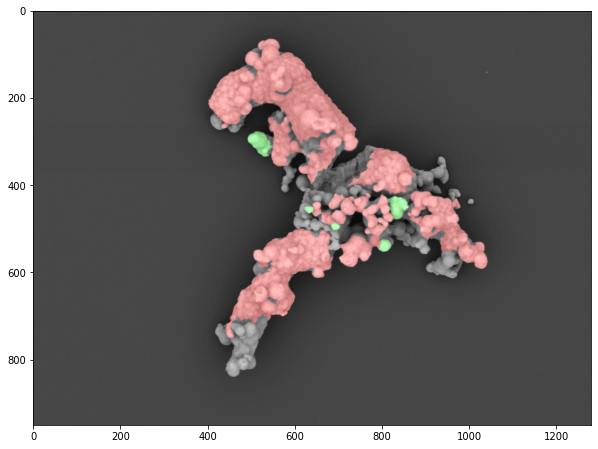

In [5]:
test = apply_coloring(ImageSegmenter(debug[0]),debug[1])
print(debug[1])
plt.figure(figsize = (10,10))
plt.imshow(test)

Image Segmenter on L1_10nM_02 created!


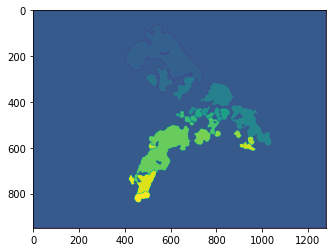

In [6]:
debug_IS = ImageSegmenter(debug[0])
plt.imshow(debug_IS.markers)

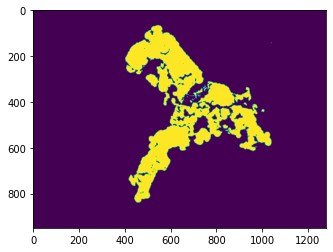

In [11]:
import matplotlib.pyplot as plt
plt.imshow(IS.thresh)

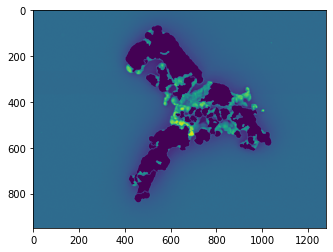

In [8]:
# Quick check so one can see what region was "forgotten" by image segmenter
img_forgotten = copy.deepcopy(IS.img2)
img_forgotten[IS.markers > 10] = 0
plt.imshow(img_forgotten)

In [9]:
# load first RF model from disk
model_name = "../Models/RF_C-MC_I-P.sav"
loaded_model = pickle.load(open(model_name, 'rb'))


/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# Prepare data
df_image_C_MC = df_image[df_image['Labels'] == 'Crystal']
        df_image_I_P = df_image[df_image['Labels'] == 'Incomplete']
        
        X_C_MC = df_image_C_MC[features]
        X_I_P = df_image_I_P[features]
        
        predicted_data_C_MC = rf_C_MC.predict(X_C_MC)
        predicted_data_I_P = rf_I_P.predict(X_I_P)
        
        labeled_arr = assign_label(predicted_data_C_MC)
        df_image_C_MC['Labels'] = labeled_arr
        labeled_arr = assign_label(predicted_data_I_P)
        df_image_I_P['Labels'] = labeled_arr
        
        df_image = pd.concat([df_image_C_MC,df_image_I_P])
        df_image.sort_values(by="Region")
        df_experiment = pd.concat([df_experiment,df_image])

df = IS.df
#print(np.unique(df["Filename"]))

# Modify Data (Remove illegal data OR set different runtime)

# Numerical errors (divide by 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
for feature in features:
    df.dropna(subset=[feature],inplace=True)

# Split Data (TO-DO)
X=df[features]

# Make adjustments to data
X=X # For RF, feature normalization NOT NEEDED

# NOTE (2022.08.24): What do I have to do with the classification afterwards???

#y
#ohe = OneHotEncoder(sparse=False)
#y = ohe.fit_transform(df[[label]])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

IndentationError: unexpected indent (1901518057.py, line 3)

In [ ]:

        
labeled_arr = assign_label(predicted_data)
IS.df['Labels'] = labeled_arr
IS.override_exists=True
IS.create_csv()
print(IS._csv_file)

In [ ]:
df_Crystal = IS.df[IS.df["Labels"] == "Crystal"]
df_Incomplete = IS.df[IS.df["Labels"] != "Crystal"]
print(f'Num Crystals: {len(df_Crystal)} \nNum Incomplete: {len(df_Incomplete)}')

In [ ]:

for ii in np.arange(len(IS.region_arr)):
    clear_output(wait=False)
    plt.imshow(IS.region_arr[ii])
    plt.show()
    print(f'Model Thinks: {labeled_arr[ii]}')
    input('Next (hit enter)')
